<a href="https://colab.research.google.com/github/Isi2000/GAN/blob/main/VGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VANILLA GAN

This notebook aims at creating an implementation of the vanilla **Vanilla GAN**
described in the first 2 chapters of YANG WANG's paper (note that it was first Goodfellow's idea)

It takes most of the code form Sovit Ranjan Rath's code **"Generating MNIST Digit Images using Vanilla GAN with PyTorch"**

In [1]:

import torch.nn.functional as F

import torchvision
import torchvision.transforms as T

from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

# keras-style network summary
from torchsummary import summary

In [2]:

import torch
from torch.utils.data import Dataset
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch.nn as nn


In [3]:
#I only need data to train, not test (this of course is half true)
training_data = MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
batch_size = 64 #small because gpu sucks

train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 276526180.54it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 56526222.04it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 134075673.62it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 12402688.00it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


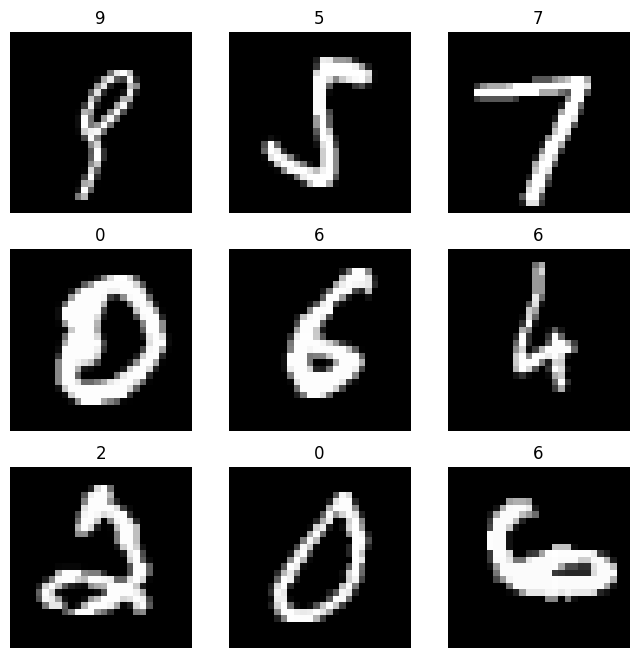

In [4]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    print(img.size())
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [5]:
if torch.cuda.is_available():
    print("Congratulations, you have a GPU!")
else:
    print("PyTorch cannot see your GPU :(")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


PyTorch cannot see your GPU :(


# Discriminator

Be careful, this nn is a bit weird. It can classify the images but its main focus is that of recognizing true images from fake ones

In [6]:
#while formally correct first implementation must choose clarity over performance
#No convolution, let's write a simple MLP

"""

class Discriminator(nn.Module):
    def __init__(self, filters: list, activation=F.leaky_relu, kernel=3):
        super().__init__()
        filters = [1] + filters
        # NOTE: never ever add layers into python's list...
        self.convs = nn.ModuleList()
        self.fc = nn.ModuleList()
        self.activation = activation

        # define convolutions
        for i, num_filters in enumerate(filters[1:]):
            conv = nn.Conv2d(in_channels=filters[i], out_channels=num_filters,
                             kernel_size=kernel, padding='same')

            self.convs.append(conv)

        self.max_pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        for i, layer in enumerate(self.convs):
            x = self.activation(layer(x))

            if i % 4 == 1:
                # downsample by 2 on 2nd conv layer
                x = self.max_pool(x)
        return F.sigmoid(x)

netG= Discriminator(filters=[4, 4, 8, 8], kernel=3).to(device)

summary(netG, (1,28,28), device ='cuda')
"""


"\n\nclass Discriminator(nn.Module):\n    def __init__(self, filters: list, activation=F.leaky_relu, kernel=3):\n        super().__init__()\n        filters = [1] + filters\n        # NOTE: never ever add layers into python's list...\n        self.convs = nn.ModuleList()\n        self.fc = nn.ModuleList()\n        self.activation = activation\n\n        # define convolutions\n        for i, num_filters in enumerate(filters[1:]):\n            conv = nn.Conv2d(in_channels=filters[i], out_channels=num_filters,\n                             kernel_size=kernel, padding='same')\n\n            self.convs.append(conv)\n\n        self.max_pool = nn.MaxPool2d(2, 2)\n\n    def forward(self, x):\n        for i, layer in enumerate(self.convs):\n            x = self.activation(layer(x))\n\n            if i % 4 == 1:\n                # downsample by 2 on 2nd conv layer\n                x = self.max_pool(x)\n        return F.sigmoid(x)\n\nnetG= Discriminator(filters=[4, 4, 8, 8], kernel=3).to(device)\

In [7]:
from torch.nn.modules.activation import LeakyReLU
nz = 256 #arbitrary size of the latent vector,

######!!!!!!!!!!!ATTENTION TO NOIZ!!!!!!!!!!!!!!!!############
#It was a really dumb way to name something, everything should work, but in case of error look here first!!!!!!!!!!
#################!!!!!!!!!!!!!!!!!!!!!!!!!###############

class Generator(nn.Module):
  def __init__(self, noise):
    super(Generator, self).__init__()
    self.noise = nz

    #usually I despise this way of working, but for such an easy case I can make an exeption
    self.main = nn.Sequential(
        nn.Linear(self.noise, 256),
        nn.LeakyReLU(0.2),

        nn.Linear(256, 512),
        nn.LeakyReLU(0.2),

        nn.Linear(512, 1024),
        nn.LeakyReLU(0.2),

        nn.Linear(1024, 784),
        nn.Tanh(),
        )
  def forward(self, x):
    return self.main(x).view(-1, 1, 28, 28)

netG = Generator(nz).to(device)
summary(netG, (1, nz), device = 'cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]          65,792
         LeakyReLU-2               [-1, 1, 256]               0
            Linear-3               [-1, 1, 512]         131,584
         LeakyReLU-4               [-1, 1, 512]               0
            Linear-5              [-1, 1, 1024]         525,312
         LeakyReLU-6              [-1, 1, 1024]               0
            Linear-7               [-1, 1, 784]         803,600
              Tanh-8               [-1, 1, 784]               0
Total params: 1,526,288
Trainable params: 1,526,288
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 5.82
Estimated Total Size (MB): 5.86
----------------------------------------------------------------


In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

netD = Discriminator().to(device)
summary(netD, (1,28,28), device = 'cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]         803,840
         LeakyReLU-2                 [-1, 1024]               0
           Dropout-3                 [-1, 1024]               0
            Linear-4                  [-1, 512]         524,800
         LeakyReLU-5                  [-1, 512]               0
           Dropout-6                  [-1, 512]               0
            Linear-7                  [-1, 256]         131,328
         LeakyReLU-8                  [-1, 256]               0
           Dropout-9                  [-1, 256]               0
           Linear-10                    [-1, 1]             257
          Sigmoid-11                    [-1, 1]               0
Total params: 1,460,225
Trainable params: 1,460,225
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [9]:
import torch.optim as optim
optim_g = optim.Adam(netG.parameters(), lr=0.0002)
optim_d = optim.Adam(netD.parameters(), lr=0.0002)

In [10]:
# loss function
criterion = nn.BCELoss()

losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

# Functions

These functions will come in handy during the training and visualization

In [11]:
# to create real labels (1s), basically real data
def label_real(size):
    """to create real labels (1s), basically real data"""
    data = torch.ones(size, 1)
    return data.to(device)
def label_fake(size):
    """to create fake labels (0s), basically fake data"""
    data = torch.zeros(size, 1)
    return data.to(device)

In [12]:
def create_noise(sample_size, noiz):
  """creates the noise vector"""
  return torch.randn(sample_size, nz).to(device) #random noise from a N(0,1), with size sample_size x noise

print(create_noise(200, 128))

tensor([[-0.3747, -0.9562, -1.3313,  ...,  0.9619, -0.4373,  1.0453],
        [ 0.2271,  0.8931, -1.4009,  ..., -1.9305, -1.0430,  0.1906],
        [-1.1576, -1.1254,  0.5095,  ...,  0.8117,  0.5200,  0.5507],
        ...,
        [ 0.6422, -0.9882,  2.0710,  ...,  0.2371,  0.0649,  1.2766],
        [-0.9815, -1.3321,  1.3702,  ...,  0.2150, -1.0882, -0.6285],
        [-0.7148,  2.1912, -0.6717,  ..., -0.0133, -0.6315,  0.2218]])


In [13]:
from torchvision.utils import save_image, make_grid

def save_gen_img(img, path):
  save_image(img, path)

#TRAINING

First we define the train functions for discriminator and generator

In [14]:
#we need to train him in order to distinguish fake images from real ones

def train_discriminator(optimizer, real_data, fake_data):
  batch_size = real_data.size(0)
  real_label = label_real(b_size)
  fake_label = label_fake(b_size)

  optimizer.zero_grad()
  output_real = netD(real_data)
  loss_real = criterion(output_real, real_label)

  output_fake = netD(fake_data)
  loss_fake = criterion(output_fake, fake_label)

  loss_real.backward()
  loss_fake.backward()
  optimizer.step()

  return loss_real + loss_fake #total loss is what intrests us the most



In [15]:
#now we need to train the gen in order to be able to fool the discriminator

def train_generator(optimizer, fake_data): #I only pass him fake data since it's the one it's producing
  batch_size = real_data.size(0)
  real_label = label_real(batch_size)

  optimizer.zero_grad()

  output = netD(data_fake) #STILL THE DISCRIMINATOR!!!!

  loss = criterion(output, real_label)

  loss.backward()
  optimizer.step()

  return loss

In [16]:
#not a great fan of tqdm, but it indeed is a great tool for data visualization
from tqdm import tqdm #progress bars


## TRAINING LOOP

In [ ]:
sepochs = 100 #num_iterations for training
k = 3 #iter to run the discriminator

for epoch in range(epochs):
  loss_g = 0.0
  loss_d = 0.0
  for batch_index, data in tqdm(enumerate(train_loader), total=int(len(training_data)/train_loader.batch_size)):

    image, _ = data
    image = image.to(device)
    b_size = len(image)

    for step in range(k):
      fake_data = netG(create_noise(b_size, nz)).detach() #img only
      real_data = image

      loss_d += train_discriminator(optim_d, real_data, fake_data)

    #here I start training the gen
    data_fake = netG(create_noise(b_size, nz))
    # train the generator network
    loss_g += train_generator(optim_g, data_fake)

    # create the final fake image for the epoch
    generated_img = netG(create_noise(b_size, nz)).cpu().detach()
    # make the images as grid
    generated_img = make_grid(generated_img)
    # save the generated torch tensor models to disk
    save_gen_img(generated_img, f"../content/outputs/gen_img{epoch}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / batch_index # total generator loss for the epoch
    epoch_loss_d = loss_d / batch_index # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    if batch_index % 100== 0:
      print(f"Epoch {epoch} of {epochs}")
      print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")






  0%|          | 2/937 [00:00<04:29,  3.47it/s]

Epoch 0 of 100
Generator loss: inf, Discriminator loss: inf


 11%|█         | 102/937 [00:20<02:34,  5.40it/s]

Epoch 0 of 100
Generator loss: 7.17934895, Discriminator loss: 1.32727921


 21%|██▏       | 201/937 [00:42<02:35,  4.73it/s]

Epoch 0 of 100
Generator loss: 8.67541695, Discriminator loss: 1.07600844


 32%|███▏      | 301/937 [01:05<02:28,  4.27it/s]

Epoch 0 of 100
Generator loss: 8.55546856, Discriminator loss: 0.81954610


 43%|████▎     | 401/937 [01:27<01:51,  4.80it/s]

Epoch 0 of 100
Generator loss: 8.44421482, Discriminator loss: 0.63462031


 53%|█████▎    | 501/937 [01:51<01:33,  4.65it/s]

Epoch 0 of 100
Generator loss: 8.95795918, Discriminator loss: 0.53971624


 64%|██████▍   | 601/937 [02:15<01:12,  4.61it/s]

Epoch 0 of 100
Generator loss: 9.13795662, Discriminator loss: 0.46845028


 75%|███████▍  | 701/937 [02:38<00:51,  4.59it/s]

Epoch 0 of 100
Generator loss: 9.47108269, Discriminator loss: 0.42220759


 85%|████████▌ | 801/937 [03:01<00:37,  3.64it/s]

Epoch 0 of 100
Generator loss: 9.84215164, Discriminator loss: 0.38569015


 96%|█████████▋| 902/937 [03:23<00:06,  5.23it/s]

Epoch 0 of 100
Generator loss: 9.94303799, Discriminator loss: 0.35787281


938it [03:31,  4.44it/s]
  0%|          | 1/937 [00:00<02:52,  5.43it/s]

Epoch 1 of 100
Generator loss: inf, Discriminator loss: inf


 11%|█         | 101/937 [00:20<03:36,  3.86it/s]

Epoch 1 of 100
Generator loss: 8.92376328, Discriminator loss: 0.06433178


 22%|██▏       | 202/937 [00:40<02:17,  5.35it/s]

Epoch 1 of 100
Generator loss: 9.59998417, Discriminator loss: 0.09600510


 32%|███▏      | 302/937 [01:01<02:12,  4.79it/s]

Epoch 1 of 100
Generator loss: 9.92203712, Discriminator loss: 0.08984212


 43%|████▎     | 401/937 [01:23<01:55,  4.62it/s]

Epoch 1 of 100
Generator loss: 10.00036812, Discriminator loss: 0.09890924


 54%|█████▎    | 502/937 [01:44<01:25,  5.08it/s]

Epoch 1 of 100
Generator loss: 10.40177631, Discriminator loss: 0.11588585


 64%|██████▍   | 601/937 [02:07<01:12,  4.62it/s]

Epoch 1 of 100
Generator loss: 10.34306240, Discriminator loss: 0.11347345


 75%|███████▍  | 701/937 [02:28<00:46,  5.05it/s]

Epoch 1 of 100
Generator loss: 10.58244991, Discriminator loss: 0.11690632


 85%|████████▌ | 801/937 [02:49<00:28,  4.72it/s]

Epoch 1 of 100
Generator loss: 10.62432003, Discriminator loss: 0.11495616


 96%|█████████▌| 901/937 [03:13<00:07,  4.70it/s]

Epoch 1 of 100
Generator loss: 10.89364243, Discriminator loss: 0.11898630


938it [03:20,  4.67it/s]
  0%|          | 1/937 [00:00<03:14,  4.82it/s]

Epoch 2 of 100
Generator loss: inf, Discriminator loss: inf


  8%|▊         | 76/937 [11:14<3:11:06, 13.32s/it]